<a href="https://colab.research.google.com/github/taiwanfifi/DL/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Data  
/house_train.csv.gz

## Outlier

在房價預測，觀察去除離群值的影響  
去除離群值有兩類方式，`調整離群值`和`捨棄離群值(刪除離群的資料) `

- 將極端值以上下限值取代，對於分布與迴歸分數的影響
- 將極端值資料直接刪除，對於分布與迴歸分數的影響

### data init

In [23]:
# 做完特徵工程前的所有準備 (與前範例相同)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data_path = 'https://github.com/taiwanfifi/DL/raw/main/data/house_train.csv.gz'
df_train = pd.read_csv(data_path)

train_Y = np.log1p(df_train['SalePrice'])
df = df_train.drop(['Id', 'SalePrice'] , axis=1)
display(df)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


In [24]:
#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')


36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



In [25]:
# 削減文字型欄位, 只剩數值型欄位，因為只透過數值來做預測
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,460,0,40,0,0,0,0,0,8,2007
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,500,349,0,0,0,0,0,0,2,2010
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,252,0,60,0,0,0,0,2500,5,2010
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,...,240,366,0,112,0,0,0,0,4,2010


### visualization

以限制 `1樓地板面積(平方英尺)` (1stFlrSF) 欄位的上下限，能否再進一步提高分數?  
- 共分成3種方式：  
  - keep outlier
  - replace outlier with upper& lower bound, use percentile 5%-95%
  - remove outlier

### method 1: keep outlier

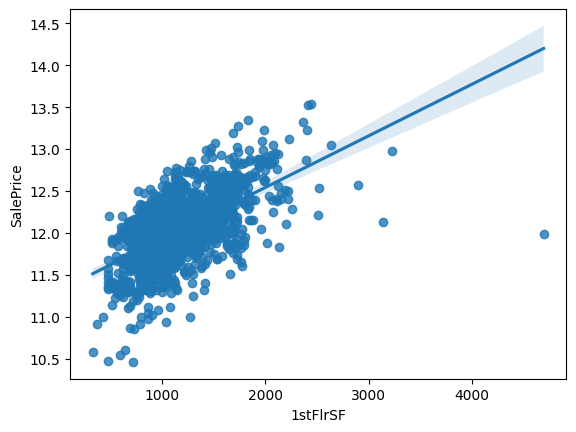

Origin Score:  0.8466207810763262


In [26]:
# 顯示 1stFlrSF 與目標值的散佈圖
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x = df['1stFlrSF'][:train_num], y=train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df) # 歸一化處理
estimator = LinearRegression()
origin_score = cross_val_score(estimator, train_X, train_Y, cv=5).mean() # cross validation 5 fold
print('Origin Score: ', origin_score)


### method 2: outlier restrict to bound

- .clip() 提供下限（lower_bound）和上限（upper_bound），函數會將所有超過這個範圍的數值替換為設定的邊界值。
  - 所有小於 lower_bound 的值會被設為 lower_bound。
  - 所有大於 upper_bound 的值會被設為 upper_bound。
  - 落在這兩個邊界之間的值不會被改變。


625.0 1981.6100000000001


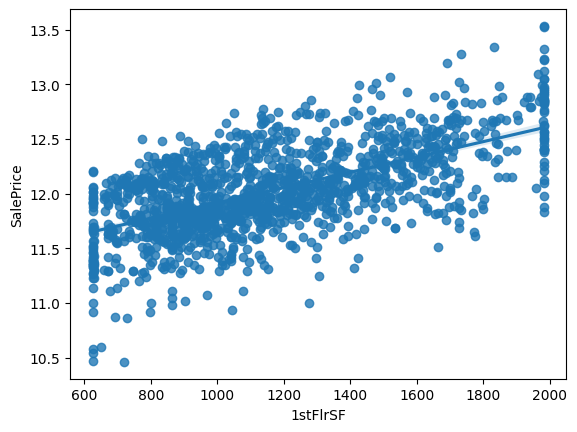

Origin Score:  0.8466207810763262
After Adjusting(1):  0.8697793334371848


In [27]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 調整離群值
## 檢查分位數，代表的值: 我這邊取3%、97%

lower_bound = np.percentile(df['1stFlrSF'], 3)
upper_bound = np.percentile(df['1stFlrSF'], 97)
print(lower_bound, upper_bound)

df['1stFlrSF'] = df['1stFlrSF'].clip(lower_bound, upper_bound)
sns.regplot(x = df['1stFlrSF'], y = train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
a1 = cross_val_score(estimator, train_X, train_Y, cv=5).mean()

print('Origin Score: ', origin_score)
print('After Adjusting(1): ', a1)


### method 3: remove outlier
`捨棄離群值`的方法，結果會變好   
解釋原因：由準確率的效果中可以看出直接拿掉離群值比調整離群值好，原因可能是調整只是去縮短數據值範圍，但這些離群值還在最邊界，所以影響還是存在的。

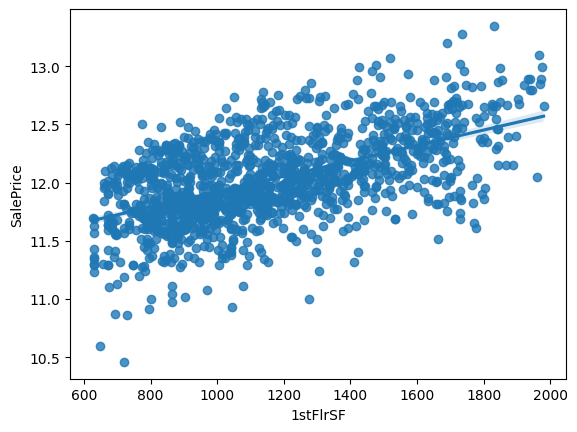

Origin Score:  0.8466207810763262
After Adjusting(1):  0.8697793334371848
After Removing(2):  0.8837433238443871


In [28]:
# 將 1stFlrSF 限制在你覺得適合的範圍內, 捨棄離群值

keep_range = (df['1stFlrSF'] > lower_bound) & (df['1stFlrSF'] < upper_bound)
df = df[keep_range]
train_Y = train_Y[keep_range]
sns.regplot(x = df['1stFlrSF'], y = train_Y)
plt.show()

# 做線性迴歸, 觀察分數
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
a2 = cross_val_score(estimator, train_X, train_Y, cv=5).mean()

print('Origin Score: ', origin_score)
print('After Adjusting(1): ', a1)
print('After Removing(2): ', a2)